In [467]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.cluster_match_functions as cmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.spatial_functions as sf
import TreeMazeAnalyses2.Analyses.open_field_functions as of
import TreeMazeAnalyses2.Analyses.plot_functions as pf


from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [27]:
%%time
ei = reload(ei)
subjects = ['Ne']
overwrite = False
update_clusters = False
for subject in subjects:
    subject_info = ei.SubjectInfo(subject, overwrite=overwrite)
    if update_clusters:
        subject_info.update_clusters()

CPU times: user 47 ms, sys: 0 ns, total: 47 ms
Wall time: 45.1 ms


In [28]:
%%time
ei = reload(ei)
overwrite=False
dm = subject_info.get_cluster_dists(overwrite=overwrite)

CPU times: user 29.5 ms, sys: 3.61 ms, total: 33.1 ms
Wall time: 34.3 ms


In [29]:
%%time
ei = reload(ei)
subject_info = ei.SubjectInfo(subject)
overwrite=False
cm  = subject_info.match_clusters(overwrite=overwrite, require_subsets=False)

CPU times: user 47.2 ms, sys: 303 µs, total: 47.5 ms
Wall time: 46 ms


In [30]:
ma = subject_info.get_session_match_analysis()
#ma

In [31]:
cmf = reload(cmf)
def get_clusters_match_info(analysis_num):
    
    n_wf = 100
    tt, d, n_cl,sessions, n_cl_session = dm[analysis_num]['analysis'].values()
    n_wf_samps = 128
    wf = np.zeros( (n_cl, n_wf, n_wf_samps))
    cl_info = pd.DataFrame(index=np.arange(n_cl), columns=['snr', 'fr', 'isi_viol', 'session', 'set_num','cl', 'session_cl_id'])
    cl_info['session_cl_id'] = dm[analysis_num]['cl_names']

    cl_cnt = 0

    for session_num, session in enumerate(sessions):
        tt_str = str(tt)
        try:
            cl_tt_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
        except KeyError:
            cl_tt_ids = subject_info.session_clusters[session]['cell_IDs'][tt_str]
        finally:
            pass

        cl_idx = np.arange(n_cl_session[session_num])+cl_cnt

        wf[cl_idx] = subject_info.get_session_tt_wf(session, tt, cluster_ids=cl_tt_ids, n_wf=n_wf)


        temp = subject_info.session_clusters[session]
        try:
            cl_info.loc[cl_idx, 'snr'] = [temp['clusters_snr'][tt][cl] for cl in cl_tt_ids]
            cl_info.loc[cl_idx, 'fr'] = [temp['clusters_fr'][tt][cl] for cl in cl_tt_ids]
            cl_info.loc[cl_idx, 'isi_viol'] = [temp['clusters_isi_viol_rate'][tt][cl] for cl in cl_tt_ids]
        except KeyError:
            cl_info.loc[cl_idx, 'snr'] = [temp['clusters_snr'][tt_str][str(cl)] for cl in cl_tt_ids]
            cl_info.loc[cl_idx, 'fr'] = [temp['clusters_fr'][tt_str][str(cl)] for cl in cl_tt_ids]
            cl_info.loc[cl_idx, 'isi_viol'] = [temp['clusters_isi_viol_rate'][tt_str][str(cl)] for cl in cl_tt_ids]
        finally:
            pass
        cl_info.loc[cl_idx, 'session'] = session
        cl_info.loc[cl_idx, 'cl'] = np.array(cl_tt_ids).astype(int)

        cl_cnt += n_cl_session[session_num]

    for set_num, cl_set in enumerate(cm[analysis_num]['matches_sets']):
        cl_info.loc[cl_info.session_cl_id.isin(cl_set), 'set_num'] = set_num

    cl_info = cl_info.astype({'set_num': int})
    
    return wf, cl_info


def plot_cluster_match_sets(set_num):
    cl_set_info = cl_info[cl_info.set_num.isin([set_num])].copy() 
    
    cl_idx = cl_set_info.index
    cl_names = cl_set_info.session_cl_id.values
    
    wfm = np.nanmean(wf[cl_idx], axis=1).T#np.median(wf[cl_idx], axis=1).T
    loc = [dm[analysis_num]['clusters_loc'][cl] for cl in cl_names]
    cov = [dm[analysis_num]['clusters_cov'][cl] for cl in cl_names]
    
    other_cl_set_info = cl_info[~cl_info.set_num.isin([set_num])].copy() 
    other_cl_names = other_cl_set_info.session_cl_id.values
    others_loc = [dm[analysis_num]['clusters_loc'][cl] for cl in other_cl_names]
    others_cov = [dm[analysis_num]['clusters_cov'][cl] for cl in other_cl_names]

    f, ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    ax[0].plot(wfm, linewidth=3)
    
    for jj in range(5):
        ax[0].axvline(32*jj, linestyle='--', color='0.2')
    
    ax[0].set_title("Waveforms")
    ax[0].set_ylabel(r"Amp [$\mu$V] ")
    
    aa=np.arange(0,129,32)
    ax[0].set_xticks(aa[:-1]+18)
    ax[0].set_xticklabels([f"ch{ch}" for ch in range(1,5)])
    
    cmf.plot_2d_cluster_ellipsoids(others_loc, others_cov, legend=False, cl_colors='grey', std_levels=[2], ax=ax[1])
    cmf.plot_2d_cluster_ellipsoids(loc, cov, cl_names=cl_names, legend=True, ax=ax[1])
    ax[1].set_title(" Clusters ")
    
    table_cols = ['snr', 'fr', 'isi_viol']
    ax[2].axis('off')
    ax[2].axis('tight')
    
    t = ax[2].table(cellText = cl_set_info[table_cols].values, colLabels=table_cols, 
                    rowColours = colors, colWidths=[0.1,0.3,0.3], loc='center')
    
    t.scale(1, 1.7)
    t.set_fontsize(14)
    t.auto_set_column_width(col=list(range(4)))
    
    
    sns.heatmap(dm[analysis_num]['dists_mats']['pe'].loc[cl_names,cl_names], annot=True, ax=ax[3])
    ax[3].set_title('PE distance')
    
    return f, ax


In [32]:
dm[0]['analysis']

{'tt': 2,
 'd': 13.0,
 'n_units': 36,
 'sessions': ['NE_T3g_052818',
  'NE_T3g_052918',
  'NE_OF_053018',
  'NE_OF_053118',
  'NE_T3g_053118',
  'NE_OF_060118',
  'Ne_T3g_060118',
  'Ne_T3g_060118_0001',
  'Ne_OF_060518',
  'NE_T3i_060618',
  'NE_OF_060718',
  'NE_OF_060818',
  'NE_T3i_061118',
  'NE_OF_061118'],
 'n_session_units': [1, 2, 4, 2, 1, 2, 2, 2, 2, 1, 2, 6, 5, 4]}

In [33]:
def see_how_many_clusters(analysis_num):
    a = dm[analysis_num]['analysis'] 
    print(f" Analysis #{analysis_num}, tt {a['tt']}, depth {a['d']}")
    print(f" Number of sessions {len(a['sessions'])}")
    print(f" Number of total clusters {a['n_units']}")
    print(f" Number of unique sets { len(cm[analysis_num]['matches_sets'])} ")
    return

interact(see_how_many_clusters,analysis_num=(0, len(dm)-1));

interactive(children=(IntSlider(value=15, description='analysis_num', max=31), Output()), _dom_classes=('widge…

In [34]:
tests_analysis_match_sets = {}
for k,a in dm.items():
    n_sets = len(cm[k]['matches_sets'])
    for ii in range(n_sets):
        TM_flag = False
        OF_flag = False
        
        for jj, cl in enumerate(cm[k]['matches_sets'][ii]):
            if 'T3' in cl:
                TM_flag = True
            if 'OF' in cl:
                OF_flag = True
        if TM_flag & OF_flag:
            if k not in tests_analysis_match_sets.keys():
                tests_analysis_match_sets[k] = []
            tests_analysis_match_sets[k] += [ii]
        
print(tests_analysis_match_sets)

{0: [2, 3, 6, 9, 12, 13, 18], 1: [1, 2], 2: [2, 3], 11: [3], 12: [0, 2], 21: [0, 1, 2, 9], 22: [0], 23: [0, 1], 25: [1, 2, 3, 5], 26: [0], 28: [0, 1], 30: [0, 3]}


## explore individual sets

In [26]:
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output

def analysis_str(analysis_num):
    tt, d, n_cl, sessions, n_cl_session = dm[analysis_num]['analysis'].values()
    out_str = f"Analysis #{analysis_num}, tt {tt}, depth {d}\n" + \
              f" Number of sessions {len(sessions)}\n" + \
              f" Number of total clusters {n_cl}\n" + \
              f" Number of unique sets { len(cm[analysis_num]['matches_sets'])} \n"
    return out_str

def on_analysis_num_change(change):
    global wf
    global cl_info
    global analysis_num
    
    analysis_num = change.new
    with out:
        analysis_labels_w.value = analysis_str(analysis_num)
    
    wf, cl_info = get_clusters_match_info(analysis_num)
    set_num_w.options = tests_analysis_match_sets[analysis_num]
    
def on_set_num_change(change):
    with out:
        clear_output()
        f, ax = plot_cluster_match_sets(change.new)
        show_inline_matplotlib_plots()
    plt.show(f)

In [35]:
%%time
analysis_num = [k for k in tests_analysis_match_sets.keys()][0]
wf, cl_info = get_clusters_match_info(analysis_num)

n_analyses = len(dm)
analysis_w = widgets.Dropdown(description='analysis_num', 
                              options=tests_analysis_match_sets.keys(), 
                              value=analysis_num)
set_num_w = widgets.Dropdown(description='set_num', 
                             options=range(len(cm[analysis_num]['matches_sets'])))
analysis_labels_w = widgets.Label(value = analysis_str(analysis_num) )

out = widgets.Output()    
analysis_w.observe(on_analysis_num_change, names='value')
set_num_w.observe(on_set_num_change, names='value')

display(analysis_w, set_num_w, analysis_labels_w, out)

Dropdown(description='analysis_num', options=(0, 1, 2, 11, 12, 21, 22, 23, 25, 26, 28, 30), value=0)

Dropdown(description='set_num', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

Label(value='Analysis #0, tt 2, depth 13.0\n Number of sessions 14\n Number of total clusters 36\n Number of u…

Output()

CPU times: user 58.9 s, sys: 14.2 s, total: 1min 13s
Wall time: 1min 16s


## using subject Li  analysis 18 to showcase method

In [40]:
%%time
ei = reload(ei)
subject = 'Li'
subject_info = ei.SubjectInfo(subject)
overwrite=False
dm = subject_info.get_cluster_dists(overwrite=overwrite)
cm  = subject_info.match_clusters(overwrite=overwrite, require_subsets=False)
subj_unit_table = subject_info.get_units_table(overwrite=True)

CPU times: user 530 ms, sys: 0 ns, total: 530 ms
Wall time: 531 ms


In [47]:
subj_unit_table[subj_unit_table.subject_cl_match_lib_id>0]

,subject_cl_id,subject,session,task,date,subsession,tt,depth,unique_cl_name,session_cl_id,unit_type,n_matches_con,subject_cl_match_con_id,n_matches_lib,subject_cl_match_lib_id,snr,fr,isi_viol_rate
2,2,Li,Li_OF_052818,OF,052818,0000,7,17.25,Li_OF_052818-tt7_d17.25_cl8,0,cell,0,41,0,41,5.09,13.56,1.13
3,3,Li,Li_OF_052818,OF,052818,0000,8,16.25,Li_OF_052818-tt8_d16.25_cl4,1,cell,1,46,1,46,10.08,2.95,0.44
4,4,Li,Li_OF_052818,OF,052818,0000,8,16.25,Li_OF_052818-tt8_d16.25_cl18,2,cell,2,54,2,54,6.6,33.03,0.54
17,17,Li,Li_T3g_052918,T3g,052918,0000,8,16.25,Li_T3g_052918-tt8_d16.25_cl0,1,cell,1,60,1,60,NaN,2.26,0.0
18,18,Li,Li_T3g_052918,T3g,052918,0000,8,16.25,Li_T3g_052918-tt8_d16.25_cl12,2,cell,0,49,0,49,NaN,6.89,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,1309,Li,Li_OF_080718,OF,080718,0000,9,21.75,Li_OF_080718-tt9_d21.75_cl12,3,cell,0,192,0,192,14.32,2.53,0.44
1310,1310,Li,Li_OF_080718,OF,080718,0000,14,19.0,Li_OF_080718-tt14_d19.0_cl9,4,cell,0,280,0,280,10.72,4.77,0.13
1311,1311,Li,Li_OF_080718,OF,080718,0000,14,19.0,Li_OF_080718-tt14_d19.0_cl10,5,cell,0,281,0,281,7.82,3.13,0.51
1312,1312,Li,Li_OF_080718,OF,080718,0000,14,19.0,Li_OF_080718-tt14_d19.0_cl17,6,cell,0,282,0,282,22.55,0.63,0.0


In [ ]:
tests_analysis_match_sets = {}
for k,a in dm.items():
    n_sets = len(cm[k]['matches_sets'])
    for ii in range(n_sets):
        TM_flag = False
        OF_flag = False
        
        for jj, cl in enumerate(cm[k]['matches_sets'][ii]):
            if 'T3' in cl:
                TM_flag = True
            if 'OF' in cl:
                OF_flag = True
        if TM_flag & OF_flag:
            if k not in tests_analysis_match_sets.keys():
                tests_analysis_match_sets[k] = []
            tests_analysis_match_sets[k] += [ii]
        
print(tests_analysis_match_sets)

In [146]:
cax = ax.figure.get_children()[2]
cax.set_position([1,0,0.1,0.25])

/tmp/ipykernel_31773/98411751.py:100: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  vals = m.lookup(c[idx[0]], c[idx[1]])


(<Figure size 450x450 with 2 Axes>, <AxesSubplot:>)

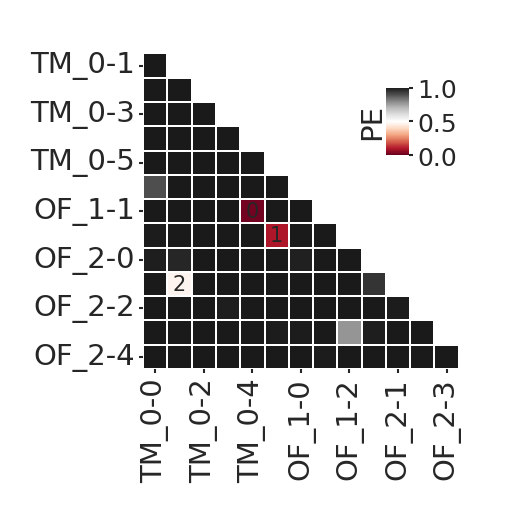

In [428]:

fontsize= 7

def extract_task_match_sets(cm, dm):
    n_units = cm['analysis']['n_units']
    sessions = cm['analysis']['sessions']
    n_session_units = cm['analysis']['n_session_units']
    
    session_map = {kk: f"se_{ii}" for kk,ii in enumerate(sessions)}
    
    cluster_map = {}
    cluster_session_cnt = np.zeros(len(sessions), dtype=int)
    for kk in dm['dists_mats']['pe']:
        for ii, se in enumerate(sessions):
            if se in kk:
                if 'OF' in se:
                    cluster_map[kk] = f"OF_{ii}-{cluster_session_cnt[ii]}"
                else:
                    cluster_map[kk] = f"TM_{ii}-{cluster_session_cnt[ii]}"
                cluster_session_cnt[ii]+=1
        
    matches_sets = cm['matches_sets']
    n_sets = len(matches_sets)
    
    task_match_set_idx = []
    for ii, match_set in enumerate(matches_sets): 
        TM_flag = False
        OF_flag = False
        for jj, element in enumerate(match_set): 
            if ('T3' in element):
                TM_flag = True
            if ('OF' in element):
                OF_flag = True

        if TM_flag & OF_flag:
            task_match_set_idx += [ii]
            
    return cluster_map, task_match_set_idx

def get_dist_mat(cm, dm, analysis_num, dist_kind='pe'):
    cols, sets = extract_task_match_sets(cm[analysis_num], dm[analysis_num])
    m = dm[analysis_num]['dists_mats'][dist_kind]
    m = m.rename(columns=cols, index=cols)
    m = m.loc[cols.values(), cols.values()]
    
    return m

def plot_distace_mat(m, cmap='RdGy', ax=None):

    c = m.columns
    mask = np.zeros_like(m)
    mask[np.triu_indices_from(mask)] = True
    
    if ax is None:   
        f,ax=plt.subplots(figsize=(1.5, 1.5), dpi=300)
    else:
        f = ax.figure
    
    # plot dist matrix on heatmap
    sns.heatmap(m, mask=mask, center=0.5, cmap=cmap, square=True, cbar=False, linewidths=0.05, ax=ax)

    # tick aesthetics
    xt = np.arange(0,len(m),2)
    yt = np.arange(1,len(m),2)
    ax.set_xticks(xt+0.5)
    ax.set_yticks(yt+0.5)
    ax.set_xticklabels(c[xt])
    ax.set_yticklabels(c[yt])

    ax.tick_params(labelsize=fontsize, pad=1, tickdir='out', tick1On=True, length=1, width=0.5)

    # colormap
    cmap_obj = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cax = f.add_axes([0.65,0.6,0.1,0.15])
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj), cax=cax)
    cax.tick_params(labelsize=fontsize-1, pad=1, tickdir='out', length=1, width=0.5)
    cax.set_aspect(3)

    cax.yaxis.set_ticks([0,0.5,1])
    cax.set_yticklabels([0.0,0.5,1.0])
    cax.set_frame_on(False)
    cax.set_ylabel('PE',fontsize=fontsize, labelpad=0)
    cax.yaxis.set_label_position('left')
    
    s = _get_cm_dist_mat_thr_idx(m)
    for ii in s.index:
        ax.text(s.rows[ii]+0.5,s.cols[ii]+0.5, str(ii), fontsize=5, ha='center', va='center')

    return f, ax
    
def _get_cm_dist_mat_thr_idx(m, cm_dist_thr=0.5):

    mask = np.zeros_like(m)
    mask[np.triu_indices_from(mask)] = True
    c = m.columns

    m2 = ((m < cm_dist_thr) & (~mask.astype(bool)))
    idx = np.where(m2)
    vals = m.lookup(c[idx[0]], c[idx[1]])
    s = pd.DataFrame(np.array((idx[1], idx[0], vals)).T, columns=['rows', 'cols', 'val'], )

    return s
    
analysis_num=18
cols, sets = extract_task_match_sets(cm[analysis_num], dm[analysis_num])
m = get_dist_mat(cm, dm, analysis_num)
plot_distace_mat(m)

/tmp/ipykernel_31773/98411751.py:100: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  vals = m.lookup(c[idx[0]], c[idx[1]])


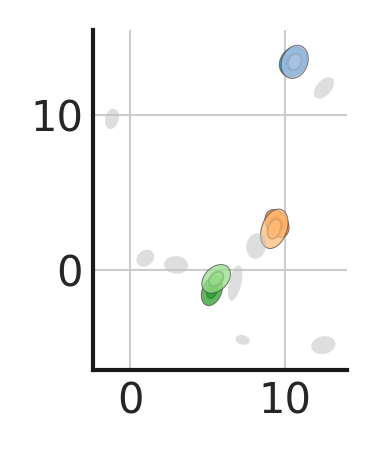

In [471]:
cmf = reload(cmf)
def plot_cluster_ellipsoids(cm, dm, analysis_num, ax=None, figsize=None):
    
    linewidths=[0.5, 0.25]
    edgecolor='0.3' 
    alpha=0.75
    
    if ax is None:
        if figsize is None:
            figsize = (1.5, 1.5)
        f, ax = plt.subplots(figsize=figsize, dpi=300)
    else:
        f = ax.figure
    
    pf.setup_axes(ax)
        
    session_name_map, matched_sets = extract_task_match_sets(cm[analysis_num],
                                                             dm[analysis_num])
    session_name_map2 = {v:k for k,v in session_name_map.items()}
    
    dist_mat = get_dist_mat(cm, dm, analysis_num)
    cl_names = dist_mat.columns
    
    sorted_match_idx = _get_cm_dist_mat_thr_idx(dist_mat)
    
    n_total_clusters = len(dist_mat)
    n_matches = len(matched_sets)
    
    pair_cols = mpl.cm.get_cmap("tab20")(np.arange(n_matches*2))
    unmatched_cols = '0.75'
    
    matched_cl_names = []
    for ii in range(n_matches):
        cl1_num = sorted_match_idx.rows[ii]
        cl2_num = sorted_match_idx.cols[ii]
        
        matched_cl_names.append(cl_names[int(cl1_num)])
        matched_cl_names.append(cl_names[int(cl2_num)])
    
    matched_cl_locs = [dm[analysis_num]['clusters_loc'][session_name_map2[cl]] 
                       for cl in matched_cl_names]
    matched_cl_cov = [dm[analysis_num]['clusters_cov'][session_name_map2[cl]] 
                       for cl in matched_cl_names]
    
    
    unmatched_cl_names = np.setdiff1d(cl_names, matched_cl_names)
    unmatched_cl_locs = [dm[analysis_num]['clusters_loc'][session_name_map2[cl]] 
                       for cl in unmatched_cl_names]
    unmatched_cl_cov = [dm[analysis_num]['clusters_cov'][session_name_map2[cl]] 
                       for cl in unmatched_cl_names]
    
    
    
    cmf.plot_2d_cluster_ellipsoids(matched_cl_locs, matched_cl_cov, legend=False, 
                                   cl_colors=pair_cols, std_levels=[1,2], linewidths=linewidths,
                                   edgecolor=edgecolor, alpha=alpha, ax=ax)
    cmf.plot_2d_cluster_ellipsoids(unmatched_cl_locs, unmatched_cl_cov, std_levels=[2], 
                                   cl_colors=unmatched_cols, linewidths=[0], ax=ax)

plot_cluster_ellipsoids(cm, dm, analysis_num)

['$TM_{0}0$' '$TM_{0}1$' '$TM_{0}2$' '$TM_{0}3$' '$TM_{0}4$' '$TM_{0}5$'
 '$OF_{1}0$' '$OF_{1}1$' '$OF_{1}2$' '$OF_{2}0$' '$OF_{2}1$' '$OF_{2}2$'
 '$OF_{2}3$' '$OF_{2}4$']


(<Figure size 2250x2250 with 2 Axes>, <AxesSubplot:>)

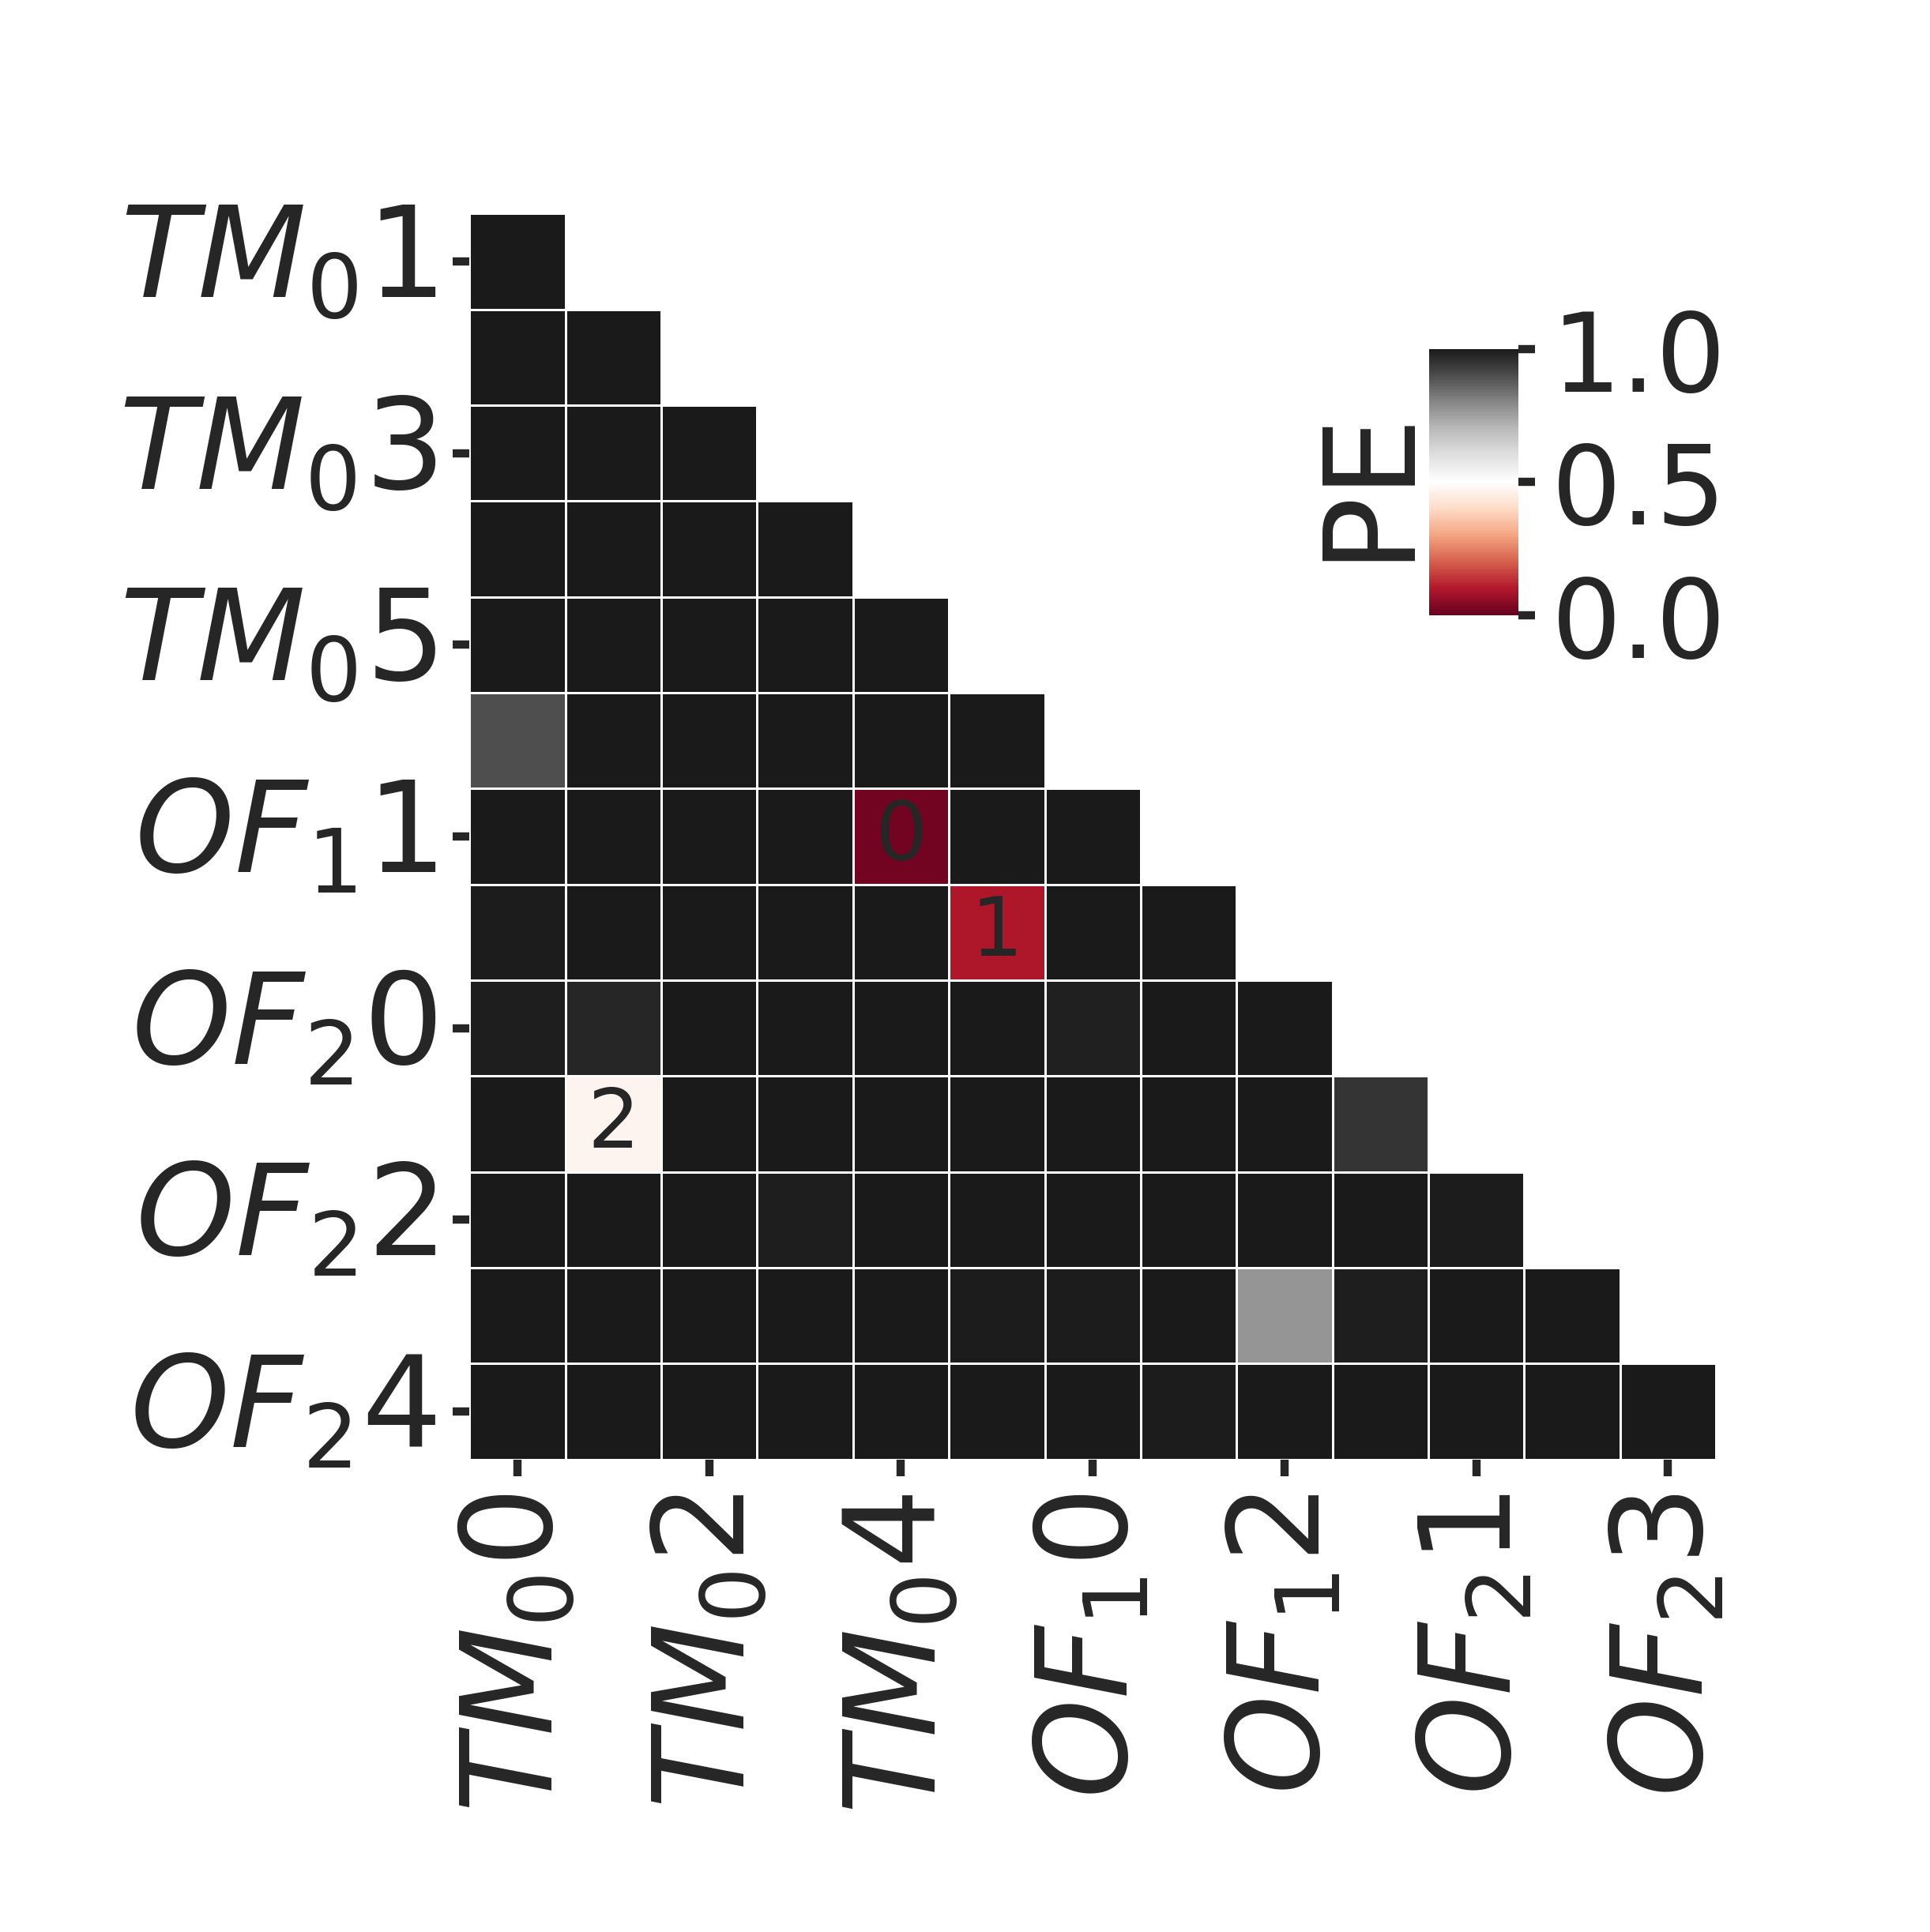

In [516]:
pf = reload(pf)
f = pf.CrossTaskFigures()
f.plot_dist_mat_session_clusters()

(<Figure size 2250x2250 with 1 Axes>,
 <AxesSubplot:xlabel='$WF_{UMAP-1}$', ylabel='$WF_{UMAP-2}$'>)

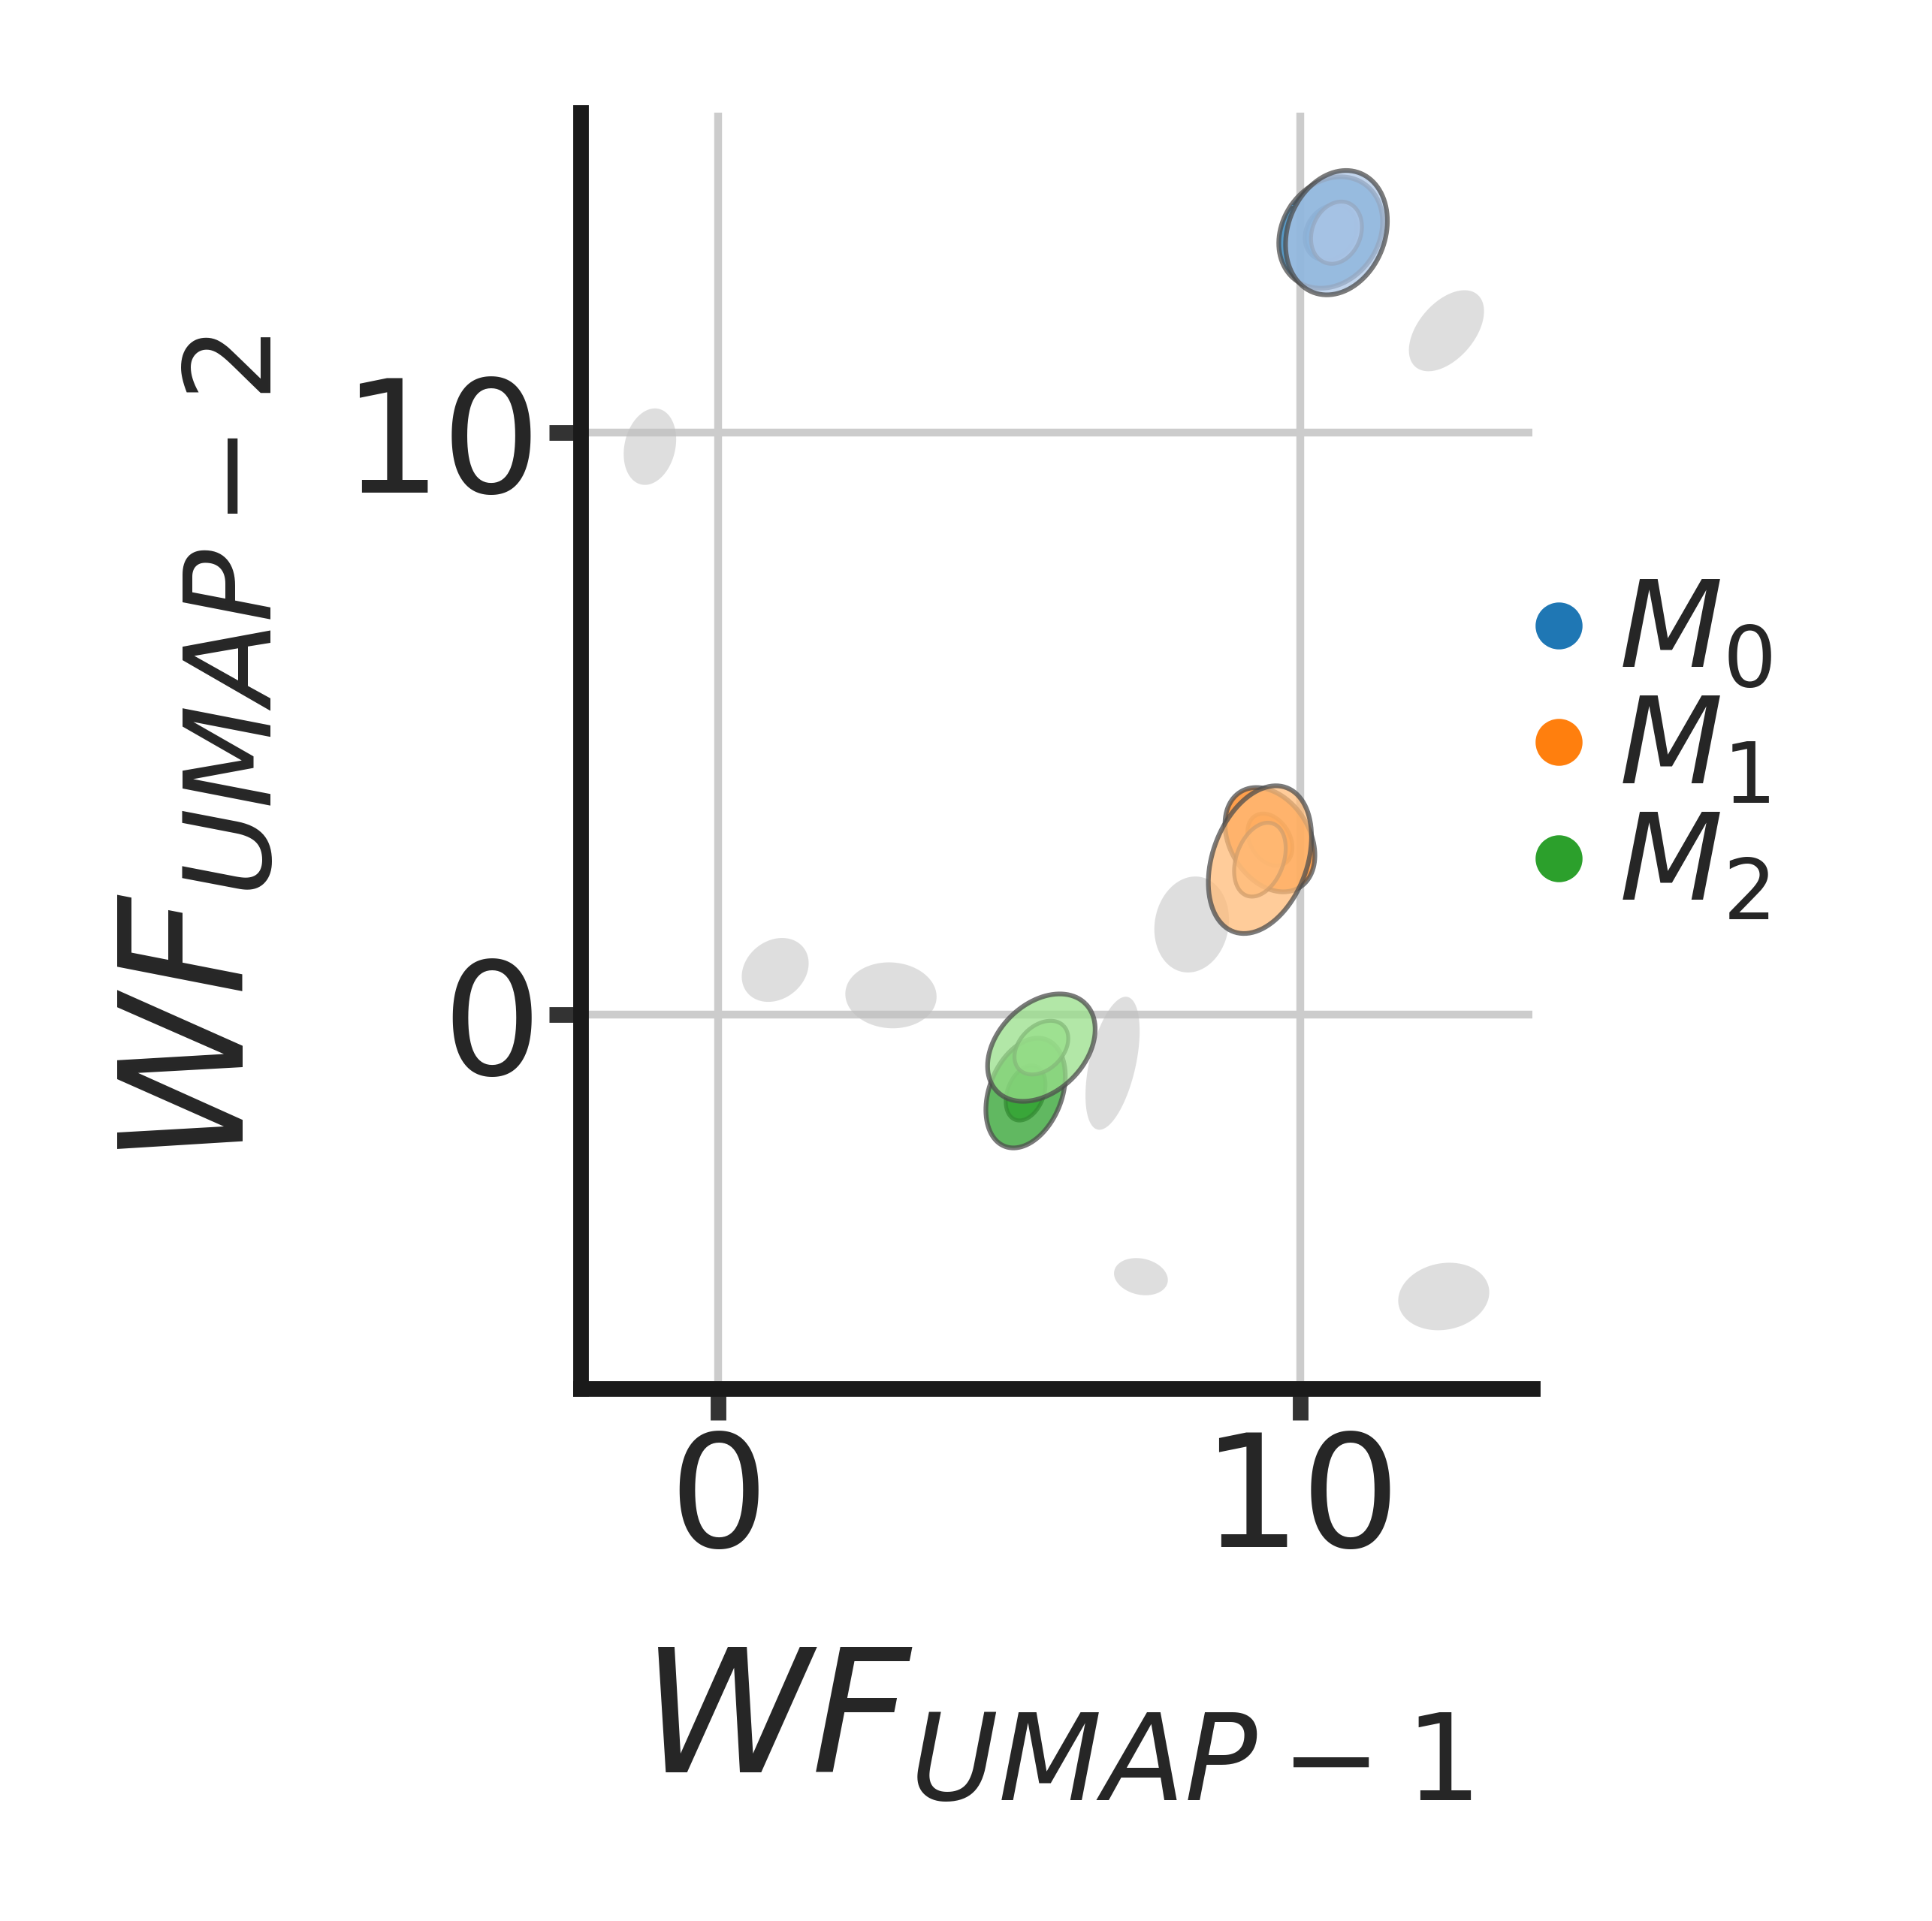

In [529]:
pf = reload(pf)
f = pf.CrossTaskFigures()
f.plot_match_units_ellipsoids()

In [549]:
%%time
pf = reload(pf)
f = pf.CrossTaskFigures()
wf, cl_full_names = f.get_match_units_wf()

CPU times: user 7.33 s, sys: 1.1 s, total: 8.42 s
Wall time: 8.44 s


In [552]:
cm, dm = f.get_cm_dm_dicts(analysis_num)
session_name_map, matched_sets = f.extract_task_match_sets(cm,dm)
dist_mat = f.get_match_dist_mat()
sorted_match_idx = _get_cm_dist_mat_thr_idx(m)


/tmp/ipykernel_31773/98411751.py:100: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  vals = m.lookup(c[idx[0]], c[idx[1]])


In [572]:
sorted_match_idx

,rows,cols,val
0,4.0,7.0,0.016352
1,5.0,8.0,0.099303
2,1.0,10.0,0.472075


In [573]:
matched_sets

[1, 4, 5]

In [586]:
matched_array_idx = []
for m in sorted_match_idx.rows:
    ms = cm['matches_sets'][int(m)]
    if len(ms)<2:
        raise ValueError
    for ss in ms:
        bool_idx =np.array(cl_full_names)==ss
        matched_array_idx.append( np.where(bool_idx)[0][0] )

matched_array_idx = np.array(matched_array_idx)



[Text(12, 0, 'ch1'),
 Text(44, 0, 'ch2'),
 Text(76, 0, 'ch3'),
 Text(108, 0, 'ch4')]

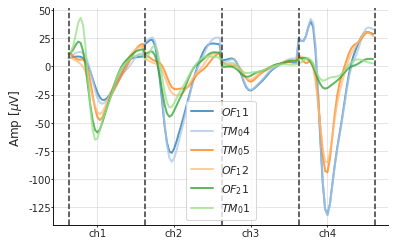

In [614]:
mwf = wf.mean(axis=1)

n_matches = len(sorted_match_idx)
cmap = mpl.cm.get_cmap("tab20")(np.arange(n_matches*2))
c2 = np.array([f"${s.split('_')[0]}_{{{s.split('_')[1][0]}}}{s.split('-')[1]}$" for s in dist_mat.columns])

n_cl = n_matches*2

labels = []
for ii in range(n_cl):
    s = session_name_map[cl_full_names[matched_array_idx[ii]]]
    labels.append(f"${s.split('_')[0]}_{{{s.split('_')[1][0]}}}{s.split('-')[1]}$")
    
f, ax=plt.subplots()
for ii in range(n_matches*2):
    ax.plot(mwf[matched_array_idx[ii]], color=cmap[ii], alpha=0.75, lw=2,
            label=labels[ii])

ax.legend()
pf.setup_axes(ax)

ax.set_xticks([])
for jj in range(5):
    ax.axvline(32*jj, linestyle='--', color='0.2')

ax.set_ylabel(r"Amp [$\mu$V] ")

aa=np.arange(0,129,32)
ax.set_xticks(aa[:-1]+12)
ax.set_xticklabels([f"ch{ch}" for ch in range(1,5)])

In [615]:
%%time
pf = reload(pf)
f = pf.CrossTaskFigures()
wf, cl_full_names = f.get_match_units_wf()

CPU times: user 7.15 s, sys: 971 ms, total: 8.12 s
Wall time: 8.13 s


In [604]:
cl_full_names[matched_array_idx[ii]]

'Li_OF_080118-tt8_d18.25_cl14'

%%time
pf = reload(pf)
f = pf.CrossTaskFigures()
f.plot_match_units_wf()

In [560]:
np.array(cl_full_names)=='Li_T3g_080118-tt8_d18.25_cl0'

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [556]:
cm['matches_sets']

[{'Li_T3g_080118-tt8_d18.25_cl0'},
 {'Li_OF_080218-tt8_d18.25_cl4', 'Li_T3g_080118-tt8_d18.25_cl1'},
 {'Li_T3g_080118-tt8_d18.25_cl2'},
 {'Li_T3g_080118-tt8_d18.25_cl4'},
 {'Li_OF_080118-tt8_d18.25_cl14', 'Li_T3g_080118-tt8_d18.25_cl11'},
 {'Li_OF_080118-tt8_d18.25_cl15', 'Li_T3g_080118-tt8_d18.25_cl12'},
 {'Li_OF_080118-tt8_d18.25_cl1'},
 {'Li_OF_080218-tt8_d18.25_cl0'},
 {'Li_OF_080218-tt8_d18.25_cl5'},
 {'Li_OF_080218-tt8_d18.25_cl12'},
 {'Li_OF_080218-tt8_d18.25_cl13'}]

In [547]:
dm[18]['cl_names']

['Li_T3g_080118-tt8_d18.25_cl0',
 'Li_T3g_080118-tt8_d18.25_cl1',
 'Li_T3g_080118-tt8_d18.25_cl2',
 'Li_T3g_080118-tt8_d18.25_cl4',
 'Li_T3g_080118-tt8_d18.25_cl11',
 'Li_T3g_080118-tt8_d18.25_cl12',
 'Li_OF_080118-tt8_d18.25_cl1',
 'Li_OF_080118-tt8_d18.25_cl14',
 'Li_OF_080118-tt8_d18.25_cl15',
 'Li_OF_080218-tt8_d18.25_cl0',
 'Li_OF_080218-tt8_d18.25_cl4',
 'Li_OF_080218-tt8_d18.25_cl5',
 'Li_OF_080218-tt8_d18.25_cl12',
 'Li_OF_080218-tt8_d18.25_cl13']

In [460]:
np.setdiff1d(cl_names, matched_cl_names)

array(['OF_1-0', 'OF_2-0', 'OF_2-2', 'OF_2-3', 'OF_2-4', 'TM_0-0',
       'TM_0-2', 'TM_0-3'], dtype=object)

In [380]:
m2 = ((m<dist_thr)&(~mask.astype(bool)))
idx = np.where(m2)
vals = m.lookup(m.columns[idx[0]],m.columns[idx[1]])
s = pd.DataFrame( np.array((idx[0],idx[1],vals)).T, columns=['rows', 'cols', 'val'], )


cnt = 0
for ii:
    ax.text(jj+0.5,ii+0.5, str(cnt), fontsize=5, ha='center', va='center')
    cnt+=1

(Index(['OF_1-1', 'OF_1-2', 'OF_2-1'], dtype='object'),
 Index(['TM_0-4', 'TM_0-5', 'TM_0-1'], dtype='object'))

In [417]:
vals = m.lookup(m.columns[idx[0]],m.columns[idx[1]])

s = pd.DataFrame( np.array((idx[0],idx[1],vals)).T, columns=['rows', 'cols', 'val'], )


Object `s.sort` not found.


/tmp/ipykernel_31773/3014280703.py:1: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  vals = m.lookup(m.columns[idx[0]],m.columns[idx[1]])


,rows,cols,val
0,7.0,4.0,0.016352
1,8.0,5.0,0.099303
2,10.0,1.0,0.472075


In [328]:
cax.set_ylabel?

,TM_0-0,TM_0-1,TM_0-2,TM_0-3,TM_0-4,TM_0-5,OF_1-0,OF_1-1,OF_1-2,OF_2-0,OF_2-1,OF_2-2,OF_2-3,OF_2-4
TM_0-0,inf,0.001599,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,4.862981e-02,-0.000000e+00,0.004692,6.409667e-03,8.105017e-06,-0.000000e+00,4.413445e-06,-0.000000
TM_0-1,0.001599,inf,7.344301e-04,8.974816e-04,2.869638e-04,5.039783e-05,2.835565e-04,2.270196e-04,0.000116,1.338392e-02,3.259894e-01,1.332413e-03,3.689308e-04,0.000048
TM_0-2,-0.000000,0.000734,inf,4.673723e-04,1.706860e-14,1.501480e-03,-0.000000e+00,6.495228e-13,0.000013,-0.000000e+00,1.957498e-07,3.582269e-04,1.658769e-05,0.000045
TM_0-3,-0.000000,0.000897,4.673723e-04,inf,2.326828e-06,3.451308e-04,-0.000000e+00,3.473569e-06,0.000248,1.027974e-06,2.679831e-05,6.063378e-03,8.210818e-07,-0.000000
TM_0-4,-0.000000,0.000287,1.706860e-14,2.326828e-06,inf,1.448420e-13,1.137798e-04,1.786435e+00,0.000678,2.417058e-11,7.318338e-04,6.947953e-04,2.356163e-04,0.002286
TM_0-5,-0.000000,0.000050,1.501480e-03,3.451308e-04,1.448420e-13,inf,4.159270e-09,2.153669e-07,1.003037,1.628799e-04,8.255607e-07,1.046062e-06,3.935973e-03,0.000305
OF_1-0,0.048630,0.000284,-0.000000e+00,-0.000000e+00,1.137798e-04,4.159270e-09,inf,1.149133e-04,0.000343,8.366397e-03,6.167990e-04,2.933933e-11,3.796366e-03,0.000010
OF_1-1,-0.000000,0.000227,6.495228e-13,3.473569e-06,1.786435e+00,2.153669e-07,1.149133e-04,inf,0.000918,1.297804e-10,6.368201e-04,6.686682e-04,2.776824e-04,0.004146
OF_1-2,0.004692,0.000116,1.253094e-05,2.479438e-04,6.780851e-04,1.003037e+00,3.425833e-04,9.177220e-04,inf,5.618839e-05,5.822962e-04,1.901131e-04,1.118978e-01,0.000385
OF_2-0,0.006410,0.013384,-0.000000e+00,1.027974e-06,2.417058e-11,1.628799e-04,8.366397e-03,1.297804e-10,0.000056,inf,2.484431e-02,1.343825e-05,6.141915e-03,0.000296


In [297]:

cax.yaxis.get_ticklocs()

array([0. , 0.5, 1. ])

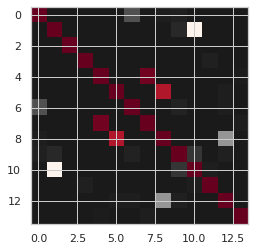

In [262]:
plt.imshow(m, cmap=cmap, mas)

In [263]:
plt.imshow?

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    *,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the colormapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the Axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`image.interpolation`.

Parameters


In [254]:
plt.colorbar?

Signature: plt.colorbar(mappable=None, cax=None, ax=None, **kw)
Docstring:
Add a colorbar to a plot.

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `~matplotlib.image.AxesImage`,
    `~matplotlib.contour.ContourSet`, etc.) described by this colorbar.
    This argument is mandatory for the `.Figure.colorbar` method but optional
    for the `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `.ScalarMappable` "on-the-fly" to generate
    colorbars not attached to a previously drawn artist, e.g. ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : `~matplotlib.axes.Axes`, optional
    Axes into which the colorbar will be drawn.

ax : `~matplotlib.axes.Axes`, list of Axes, optional
    One or more parent axes from which space for a new colorbar axes will be
    stolen, if *cax* is None.  This has no effect if *cax* is set.

use_gridspec : bool, optional
    If *cax* is ``None

In [250]:
cax.set_yticks(np.arange(0,1,3))
cax.get_yticks()

array([0.5, 1. ])

In [120]:
cm[18]

{'analysis': {'tt': 8,
  'd': 18.25,
  'n_units': 14,
  'sessions': ['Li_T3g_080118', 'Li_OF_080118', 'Li_OF_080218'],
  'n_session_units': [6, 3, 5]},
 'matches_dict': {'Li_T3g_080118-tt8_d18.25_cl0': [set()],
  'Li_OF_080218-tt8_d18.25_cl4': [{'Li_T3g_080118-tt8_d18.25_cl1'}],
  'Li_T3g_080118-tt8_d18.25_cl1': [{'Li_OF_080218-tt8_d18.25_cl4'}],
  'Li_T3g_080118-tt8_d18.25_cl2': [set()],
  'Li_T3g_080118-tt8_d18.25_cl4': [set()],
  'Li_OF_080118-tt8_d18.25_cl14': [{'Li_T3g_080118-tt8_d18.25_cl11'}],
  'Li_T3g_080118-tt8_d18.25_cl11': [{'Li_OF_080118-tt8_d18.25_cl14'}],
  'Li_T3g_080118-tt8_d18.25_cl12': [{'Li_OF_080118-tt8_d18.25_cl15'}],
  'Li_OF_080118-tt8_d18.25_cl15': [{'Li_T3g_080118-tt8_d18.25_cl12'}],
  'Li_OF_080118-tt8_d18.25_cl1': [set()],
  'Li_OF_080218-tt8_d18.25_cl0': [set()],
  'Li_OF_080218-tt8_d18.25_cl5': [set()],
  'Li_OF_080218-tt8_d18.25_cl12': [set()],
  'Li_OF_080218-tt8_d18.25_cl13': [set()]},
 'matches_sets': [{'Li_T3g_080118-tt8_d18.25_cl0'},
  {'Li_OF_080218

In [89]:
subj_unit_table[(subj_unit_table.session=='Li_T3g_080118')&(subj_unit_table.unit_type=='cell')]

,subject_cl_id,subject,session,task,date,subsession,tt,depth,unique_cl_name,session_cl_id,unit_type,n_matches_con,subject_cl_match_con_id,n_matches_lib,subject_cl_match_lib_id,snr,fr,isi_viol_rate
1229,1229,Li,Li_T3g_080118,T3g,080118,0000,8,18.25,Li_T3g_080118-tt8_d18.25_cl0,0,cell,0,174,0,174,14.46,5.45,0.0
1230,1230,Li,Li_T3g_080118,T3g,080118,0000,8,18.25,Li_T3g_080118-tt8_d18.25_cl1,1,cell,1,175,1,175,6.0,5.99,0.12
1231,1231,Li,Li_T3g_080118,T3g,080118,0000,8,18.25,Li_T3g_080118-tt8_d18.25_cl2,2,cell,0,176,0,176,5.33,3.63,0.07
1232,1232,Li,Li_T3g_080118,T3g,080118,0000,8,18.25,Li_T3g_080118-tt8_d18.25_cl4,3,cell,0,177,0,177,11.32,10.62,0.0
1233,1233,Li,Li_T3g_080118,T3g,080118,0000,8,18.25,Li_T3g_080118-tt8_d18.25_cl11,4,cell,1,178,1,178,13.52,11.69,0.0
1234,1234,Li,Li_T3g_080118,T3g,080118,0000,8,18.25,Li_T3g_080118-tt8_d18.25_cl12,5,cell,1,179,1,179,10.03,2.47,0.08
1235,1235,Li,Li_T3g_080118,T3g,080118,0000,10,19.75,Li_T3g_080118-tt10_d19.75_cl1,6,cell,2,231,2,231,5.52,6.16,0.09
1236,1236,Li,Li_T3g_080118,T3g,080118,0000,10,19.75,Li_T3g_080118-tt10_d19.75_cl10,7,cell,1,232,1,232,5.13,11.9,0.06


<AxesSubplot:>

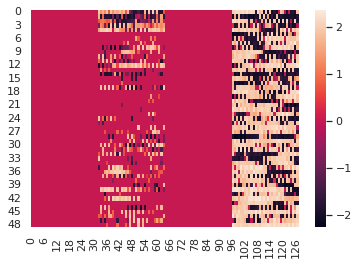

In [215]:
sns.heatmap(np.nanmedian(wf,axis=1))

In [252]:
session = 'Li_T3g_062018'
a = subject_info.get_session_tt_wf(session, tt, cluster_ids=cl_tt_ids, n_wf=n_wf)

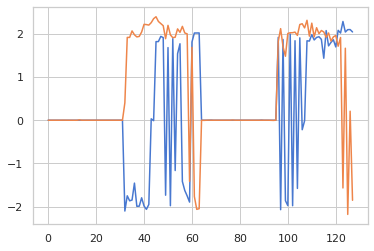

In [253]:
plt.plot(np.nanmedian(a,axis=1).T)

In [254]:
session_info = ei.SubjectSessionInfo(subject, session)

In [268]:
session_info.sort_tables['summary'].loc[session]

n_tt                16.0
n_tt_sorted          9.0
n_tt_curated         5.0
n_valid_clusters     NaN
n_cell               7.0
n_mua               19.0
n_noise             54.0
n_unsorted          63.0
Name: Li_T3g_062018, dtype: float64

In [277]:
tt_info = session_info.get_tt_info(10)
tt_info.keys()

dict_keys(['data_dir', 'session', 'fs', 'tt_num', 'n_chans', 'chan_files', 'a_ds', 'ref_chan', 'chan_ids', 'input_range', 'tt_geom', 'bad_chan_thr', 'n_samps', 'tB', 'tE', 'Raw', 'chan_code', 'bad_chans'])

In [280]:
tt_data = session_info.get_tt_data(10)

In [299]:
a = session_info.get_session_tt_wf(session, 10,n_wf=100)

<AxesSubplot:>

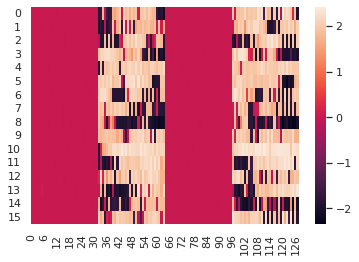

In [300]:
sns.heatmap(np.nanmedian(a,axis=1))

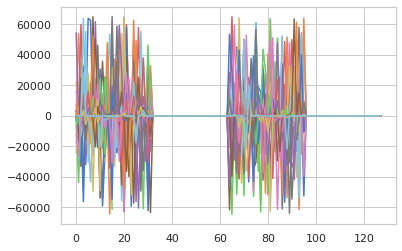

In [344]:
plt.plot(a[0].T)

In [325]:
import Sorting.sort_functions as sort_funcs

tt_str = 'tt_' + str(tt)
_sort_path = Path(subject_info.session_paths[session]['Sorted'], tt_str, self.sorter)
_cluster_spike_time_fn = _sort_path / 'spike_times.npy'
_cluster_spike_ids_fn = _sort_path / 'spike_clusters.npy'
_hp_data_fn = _sort_path / 'recording.dat'

hp_data = sort_funcs.load_hp_binary_data(_hp_data_fn)
spike_times = np.load(_cluster_spike_time_fn)
spike_ids = np.load(_cluster_spike_ids_fn)

In [314]:
np.nanmax(raw_data[0][:100000]), np.nanmin(raw_data[0][:100000])

(315.5, -428.5)

In [315]:
hp_data2=subject_info._spk_filter_data(session,tt)

In [316]:
np.nanmax(hp_data2[0][:100000]), np.nanmin(hp_data2[0][:100000])

(93.9, -140.0)

In [321]:
hp_data.shape[1]/hp_data2.shape[1]

2.0

In [362]:
_hp_data_fn.stat().st_size

1480949760

In [364]:
tt_str = 'tt_' + str(tt)
pp_data_fn = self.session_paths[session]['PreProcessed'] / (tt_str + '.npy')
_hp_data_fn.stat().st_size/pp_data_fn.stat().st_size

1.9999996542759753

In [356]:
hp_data3 = np.fromfile(_hp_data_fn)

In [357]:
hp_data3.shape, hp_data.shape[0]*hp_data.shape[1],hp_data2.shape[0]*hp_data2.shape[1] 

((185118720,), 740474880, 370237440)

In [145]:
#subject_info.get_session_tt_wf(session, tt, cluster_ids=cl_tt_ids, n_wf=n_wf)
cl_idx = np.arange(n_cl_session[session_num])+cl_cnt

In [159]:
a = subject_info.get_session_tt_wf(session, tt, cluster_ids=cl_tt_ids, n_wf=n_wf)
a.shape

(1, 100, 128)

In [167]:
wf[cl_idx] = a
wf[cl_idx]
wf

array([[[ 1.624e-01,  3.588e+01, -2.385e+00, ...,  2.418e+00,
          2.395e+00,  2.324e+00],
        [-2.789e-02, -3.276e-04, -1.405e-01, ..., -2.133e+00,
         -1.654e+00, -1.794e+00],
        [ 1.757e-01,  2.742e-01, -1.625e+04, ...,  2.750e+00,
          2.631e+00,  2.574e+00],
        ...,
        [-1.210e-05, -2.510e+00,  1.254e+04, ...,  2.316e+00,
          2.727e+00,  1.913e+00],
        [ 2.483e-03, -2.350e-02,  1.383e+03, ..., -2.771e+00,
         -3.018e+00, -2.596e+00],
        [ 3.798e-03, -1.139e-04, -2.678e+01, ...,  2.602e+00,
          2.711e+00,  2.592e+00]],

       [[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        ...,
        [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 0.

In [150]:
[subject_info.session_clusters[session]['clusters_snr'][str(tt)][str(cl)] for cl in cl_tt_ids]
#subject_info.session_clusters[session]['clusters_snr']

[nan]

In [139]:
wf, cl_info = get_clusters_match_info(analysis_num)

In [140]:
cl_info

,snr,fr,isi_viol,session,set_num,cl,session_cl_id
0,NaN,NaN,NaN,NaN,1,NaN,Li_OF_062918-tt8_d17.25_cl0
1,NaN,NaN,NaN,NaN,2,NaN,Li_OF_062918-tt8_d17.25_cl1
2,NaN,NaN,NaN,NaN,3,NaN,Li_OF_062918-tt8_d17.25_cl2
3,NaN,NaN,NaN,NaN,4,NaN,Li_OF_062918-tt8_d17.25_cl5
4,NaN,NaN,NaN,NaN,7,NaN,Li_OF_062918-tt8_d17.25_cl7
5,NaN,NaN,NaN,NaN,8,NaN,Li_OF_062918-tt8_d17.25_cl13
6,NaN,NaN,NaN,NaN,10,NaN,Li_OF_062918-tt8_d17.25_cl18
7,NaN,NaN,NaN,NaN,11,NaN,Li_T3g_062918-tt8_d17.25_cl0
8,NaN,NaN,NaN,NaN,12,NaN,Li_T3g_062918-tt8_d17.25_cl1
9,NaN,NaN,NaN,NaN,7,NaN,Li_T3g_062918-tt8_d17.25_cl3


In [36]:
n_units = 0 
n_unique_units = 0
for analysis_num in dm.keys():
    tt, d, n_cl, sessions, n_cl_session = dm[analysis_num]['analysis'].values()
    n_units += n_cl
    n_unique_units += len(cm[analysis_num]['matches_sets'])

print(f"Total Units: {n_units}")
print(f"Total Unique: {n_unique_units}")

Total Units: 163
Total Unique: 112


<AxesSubplot:>

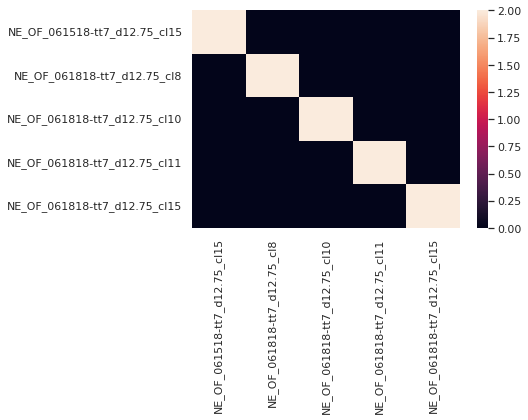

In [37]:

sns.heatmap( 1.0*(dm[14]['dists_mats']['he']<0.5)
            + (dm[14]['dists_mats']['pe']<0.5) )

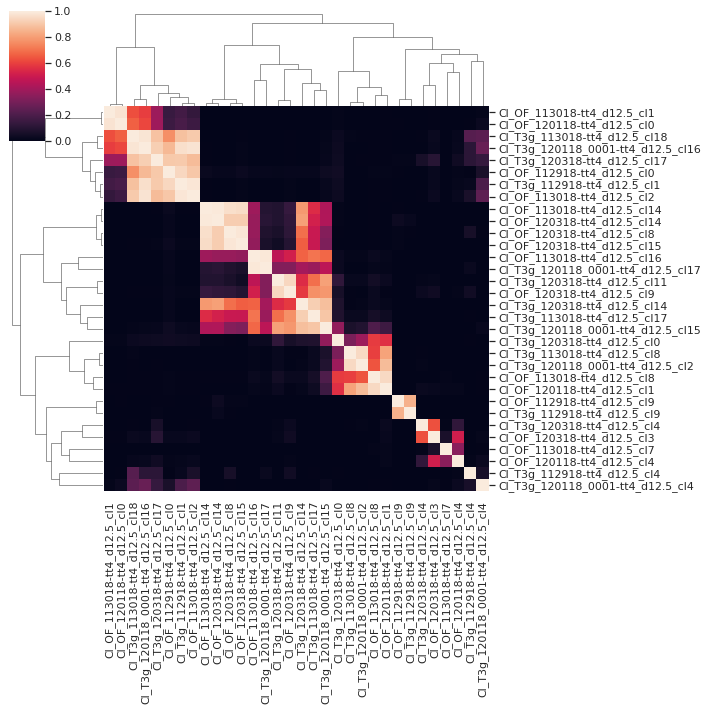

In [326]:
sns.clustermap(1-dm[14]['dists_mats']['pe']/dm[14]['dists_mats']['pe'].max())

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


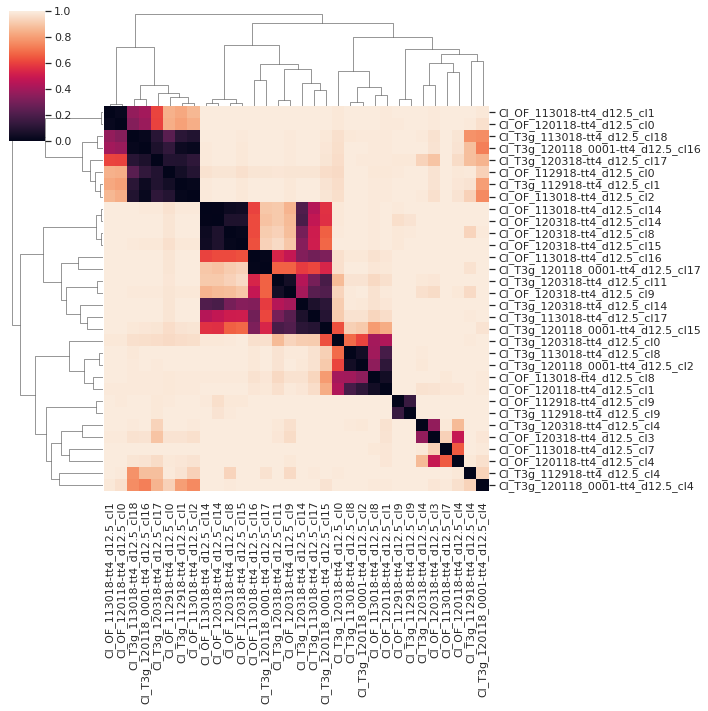

In [328]:
sns.clustermap(dm[14]['dists_mats']['pe'])